In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('hotel_bookings.csv')
df.shape

(119390, 32)

In [3]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [3]:
#Droprows having missing values except for variables like Agent or Company,
#“NULL” is presented as one of the categories.
df1 = df.dropna(axis=0,how = "any",subset=['children', 'country'])
df1.shape

(118898, 32)

In [4]:
#Change arrival year, month and day feature to datetime format called arrival_date.
df1 = df1.astype({"arrival_date_year": str, "arrival_date_month": str, "arrival_date_day_of_month": str})
df1['arrival_date'] = df1[['arrival_date_day_of_month','arrival_date_month','arrival_date_year']].agg('-'.join, axis=1)
df1.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1-July-2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1-July-2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1-July-2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1-July-2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,1-July-2015


In [5]:
df1['arrival_date']= pd.to_datetime(df1['arrival_date'])

In [6]:
## If no id of agent or company is null, just replace it with 0
df1[['agent','company']] = df1[['agent','company']].fillna(0.0)

In [7]:
## For the missing values in the country column, replace it with mode (value that appears most often)
df1['country'].fillna(df.country.mode().to_string(), inplace=True)


## for missing children value, replace it with rounded mean value
df1['children'].fillna(round(df.children.mean()), inplace=True)

In [8]:
## Drop Rows where there is no adult, baby and child
df1 = df1.drop(df1[(df1.adults+df1.babies+df1.children)==0].index)

In [9]:
## convert datatype of these columns from float to integer
df1[['children', 'company', 'agent']] = df1[['children', 'company', 'agent']].astype('int64')

In [10]:
# First copy the dataset, so our original dataset remains unchanged
data = df1.copy()

## B.1 Exploratory Data Analysis ( correlation ) 

In [11]:
correlation = data.corr()["is_canceled"]
correlation.abs().sort_values(ascending=False)[1:]

lead_time                         0.291602
total_of_special_requests         0.235923
required_car_parking_spaces       0.195012
booking_changes                   0.145136
previous_cancellations            0.109909
is_repeated_guest                 0.084141
company                           0.082204
adults                            0.056130
previous_bookings_not_canceled    0.055502
days_in_waiting_list              0.054113
agent                             0.046859
adr                               0.044885
babies                            0.032605
stays_in_week_nights              0.024803
arrival_date_week_number          0.007664
children                          0.004535
stays_in_weekend_nights           0.002223
Name: is_canceled, dtype: float64

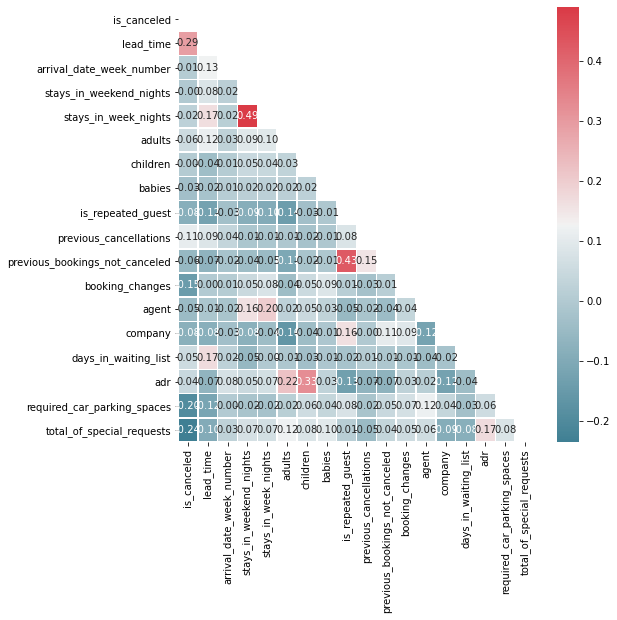

In [12]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

Based on the codes above, we can conclude than the features who have the biggest correlation to the target ('is_cancelled') are required_car_parking_spaces, lead_time, booking_changes, adr, and adults.

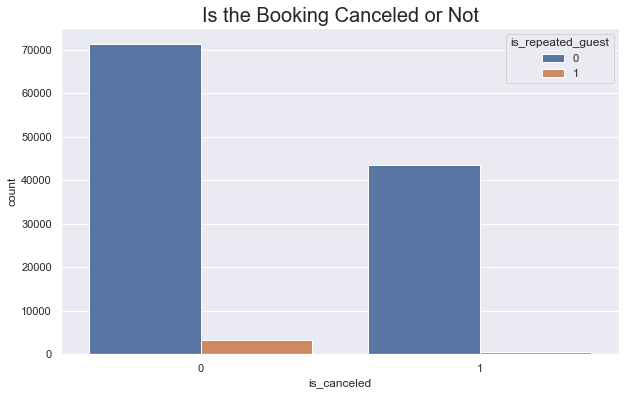

In [13]:
plt.figure(figsize=(10,6))
sns.set(style = "darkgrid")
plt.title("Is the Booking Canceled or Not", fontdict = {'fontsize': 20})
axis = sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = data)
# with 0 is the not cancelled booking, and 1 is the cancelled bookings.

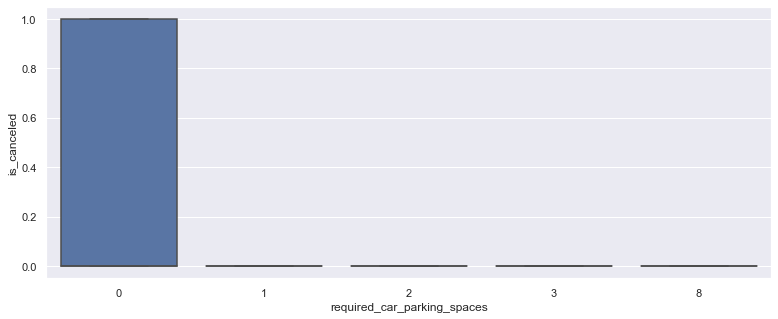

In [14]:
plt.figure(figsize = (13,5))
sns.boxplot(x = 'required_car_parking_spaces', y = 'is_canceled', data = data);

In [17]:
data[data['required_car_parking_spaces'] == 0]['is_canceled'].value_counts()

0    67287
1    44138
Name: is_canceled, dtype: int64

From the visualizations above, most of the bookings canceled came from those who only require 1 parking space.

<AxesSubplot:xlabel='arrival_date_month', ylabel='adults'>

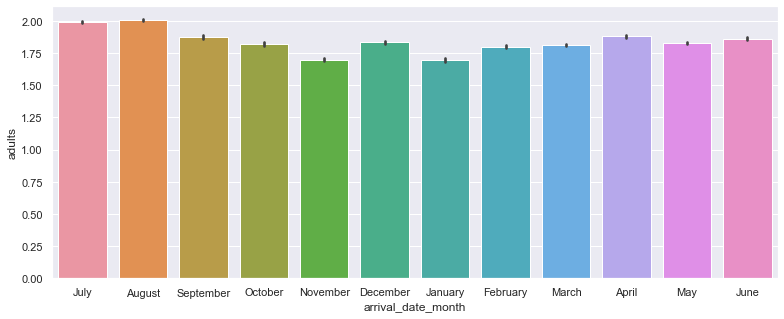

In [18]:
plt.figure(figsize = (13,5))
sns.barplot(x ='arrival_date_month', y = 'adults', data = data)

Based on the plot above, most of the adults arrive at their hotels in July and August, with over 2.0 adults.The barplot gives us the mean of adults not their sum.

In [26]:
data[data['arrival_date_month'] == "November"]['adults'].mean()

1.6994503045609866

<AxesSubplot:xlabel='is_canceled', ylabel='lead_time'>

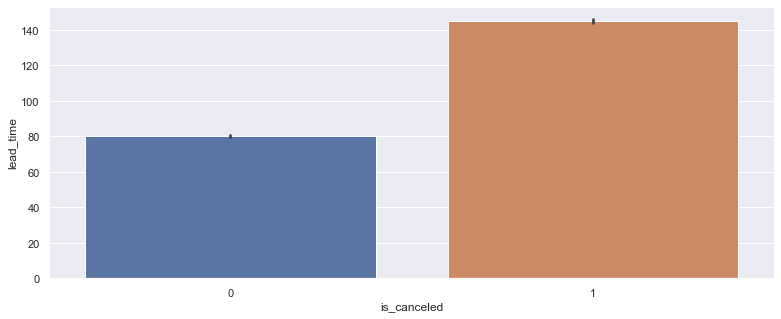

In [27]:
plt.figure(figsize = (13,5 ))
sns.barplot(x ='is_canceled', y = 'lead_time', data = data)

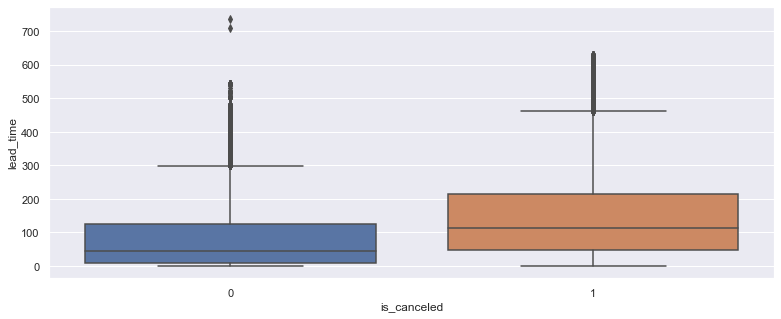

In [28]:
plt.figure(figsize = (13,5))
sns.boxplot(x = 'is_canceled', y = 'lead_time', data = data);

The plots above suggest that people who cancelled their hotel bookings have more lead time (the difference between the time they book and the day they arrived) than those who did not cancal their bookings. we do the same for adr 

.

In [13]:
data.describe()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000
mean,0.371757,104.401312,27.165100,0.928307,2.500918,1.861052,0.104356,0.007959,0.031593,0.087208,0.131612,0.218828,74.951065,10.546855,2.330638,102.133442,0.061915,0.571778
std,0.483276,106.915284,13.586362,0.992725,1.889089,0.574697,0.399439,0.097449,0.174915,0.846419,1.485300,0.638914,107.170463,53.462466,17.633065,50.389602,0.244230,0.792740
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,70.000000,28.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,38.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,153.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,53.000000,16.000000,40.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<a id='explore'></a>

## Exploring Data

### First, how many Resort Hotels and City Hotels we have in our data?

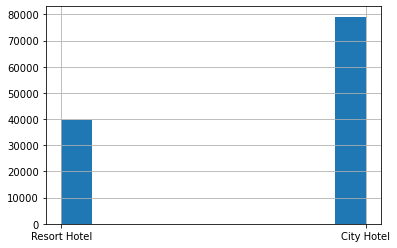

In [20]:
data.hotel.hist()
plt.show()

We can see that the majority of our data is in city hotel, we're going to split our data to resort and city dataframe

In [11]:
resort = data[data.hotel == "Resort Hotel"].drop("hotel",axis = 1)
city_ht = data[data.hotel == "City Hotel"].drop("hotel",axis = 1)

### When are the high, middle and low season?

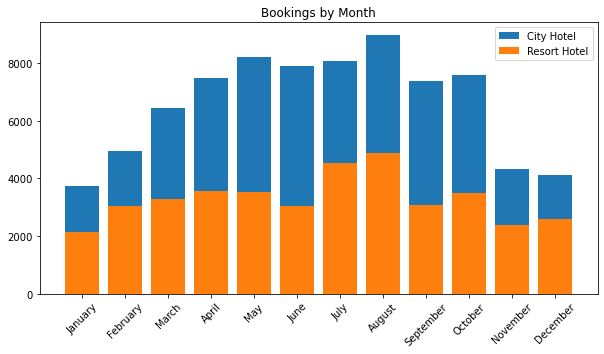

In [12]:
order = ['January','February', 'March', 'April', 'May', 'June',\
         'July', 'August', 'September', 'October', 'November', 'December']


fig, ax = plt.subplots(figsize=(10,5))
ax.bar(order, city_ht['arrival_date_month'].value_counts()[order],label='City Hotel')
ax.bar(order, resort['arrival_date_month'].value_counts()[order],label='Resort Hotel')
ax.set_xticklabels(order,rotation=45)
ax.set_title('Bookings by Month')
ax.legend()
plt.show()

We see that August has the majority of the bookings, both for City Hotels and Resort Hotels. We could classify the seasons as:

- low season: __January, December, November, February__

- middle season: __March, September, April, October__

- high season: __June, July, May, August__

### What are the features of cancelled bookings?

#### Cancellations by Month

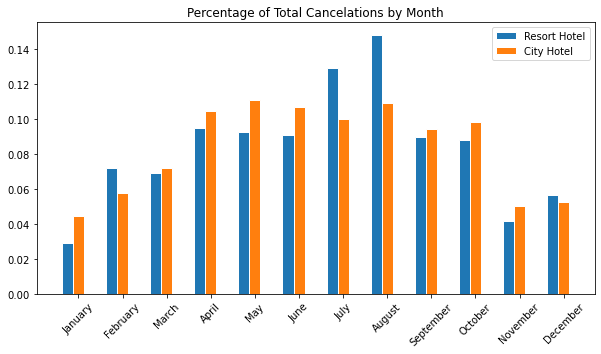

In [16]:
def v_counts(dff,x):
    return dff.loc[dff.is_canceled==1,x].value_counts(normalize=True)

barWidth = 0.25

x_axis = np.arange(len(order))

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x_axis,v_counts(resort,'arrival_date_month')[order],label='Resort Hotel',width=barWidth,edgecolor='white')
ax.bar([x + barWidth for x in x_axis],v_counts(city_ht,'arrival_date_month')[order]\
       ,label='City Hotel',width=barWidth,edgecolor='white')
plt.xticks(x_axis+barWidth,order,rotation=45)
ax.set_title('Percentage of Total Cancelations by Month')
ax.legend()
plt.show()

As we can see, most cancellations happen in the high season. Which is expected, since most reservations are being done.

## C. MODEL BUILDING & HYPERPARAMETER TUNING

In [11]:
df2 = data.copy()
data2 = df2[['is_canceled','required_car_parking_spaces','lead_time','booking_changes','adr','adults']]
data3 = data2.iloc[0:2999]
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 3001
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_canceled                  2999 non-null   int64  
 1   required_car_parking_spaces  2999 non-null   int64  
 2   lead_time                    2999 non-null   int64  
 3   booking_changes              2999 non-null   int64  
 4   adr                          2999 non-null   float64
 5   adults                       2999 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 164.0 KB


In [12]:
df2 = data.copy()
data2 = df2[['is_canceled','required_car_parking_spaces','lead_time','booking_changes','adr','adults']]
data3 = data2.copy()
X = data3.drop(['is_canceled'], axis=1)
y = data3['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
log = LogisticRegression().fit(X_train, y_train)
print("log.coef_: {}".format(log.coef_))
print("log.intercept_: {}".format(log.intercept_))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [14]:
dict = {"xtrain": X_train.shape, "ytrain": y_train.shape,"xtest": X_test.shape, "ytest": y_test.shape}
dict

{'xtrain': (2399, 5), 'ytrain': (2399,), 'xtest': (600, 5), 'ytest': (600,)}

In [15]:
log = LogisticRegression().fit(X_train, y_train)

In [16]:
print("log.coef_: {}".format(log.coef_))
print("log.intercept_: {}".format(log.intercept_))

log.coef_: [[-4.05779633  0.00655547 -0.77285235  0.0097256   0.08433395]]
log.intercept_: [-2.00015595]


In [17]:
y_pred = log.predict(X_test)

### Model Performance

In [60]:
print("Training set score: {:.2f}".format(log.score(X_train, y_train)))
print("Test set score: {:.2f}".format(log.score(X_test, y_test)))

Training set score: 0.69
Test set score: 0.69


without the standard scaler we have : Training set score: 0.60 - Test set score: 0.22
with the standard scaler we have : Training set score: 0.68 -  Test set score: 0.57
if we reduce the number of lines then we increases the performance
 with the standardscaler and iloc we have train 0.68 and test 0.69

### Evaluation Model

In [61]:
confusion_matrix(y_test,y_pred)

array([[410,   1],
       [184,   5]], dtype=int64)

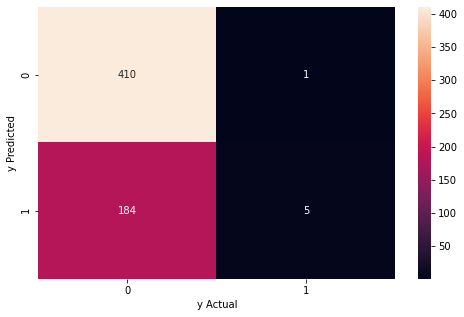

In [62]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Actual')
plt.ylabel('y Predicted')
plt.show()

On this model, we can see that False Negative (Predicted 0, Actual 1). That is something that we need to be concerned about, because I think it is something that could produce the most loss for the company. If that happens, the company wrongly predict that someone that actually canceled the book, but noted that they are not cancelling their bookings. By that reason, the company did not gain money becuase those people did not pay the company.

## Part 2: Diving Into Some Details

### Exercise 1

What is the distribution of the average daily rate (ADR)? Do you notice anything peculiar about this distribution? If so, and if you think something should be done about it, state it and do that. Also, approximate the mean and standard deviation of this distribution by eye, and then compare with the actual values.

In [18]:
data = data.dropna()

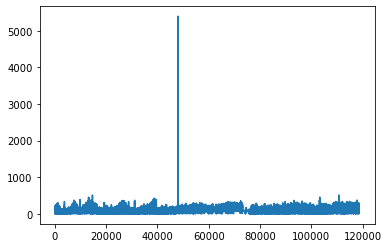

In [19]:
plt.plot(data['adr'].values)

In [21]:
max_adr = (max(data['adr']))
print(max_adr)

5400.0


In [22]:
data.drop(data.loc[data['adr'] == max_adr].index, inplace = True)

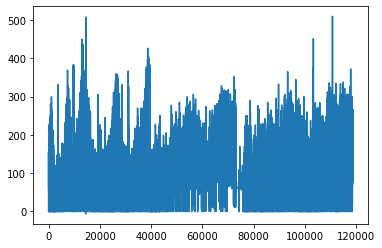

In [23]:
plt.plot(data['adr'].values)

#### Standardize the ADR feature
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

In [24]:
cols_to_norm = ['adr']
data[cols_to_norm] = StandardScaler().fit_transform(data[cols_to_norm])

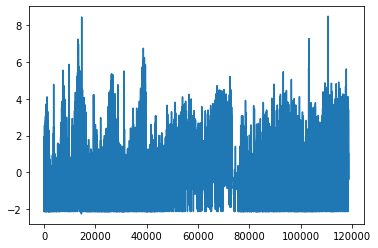

In [25]:
plt.plot(data['adr'].values)

By checking with just eye it looks that mean is near to zero and std is near to 1, we can verify it

How would you investigate the relationships between the various features of the data? Explainand demonstrate

In [34]:
corr_matrix = data.corr()
corr_matrix

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.291612,0.007676,-0.002212,0.024812,0.056128,0.004537,-0.032605,-0.084140,0.109911,-0.055502,-0.145152,-0.046853,-0.082203,0.054114,0.045924,-0.195011,-0.235917
lead_time,0.291612,1.000000,0.126870,0.084322,0.165909,0.115022,-0.038581,-0.021231,-0.123868,0.085948,-0.071164,0.002133,-0.013777,-0.083299,0.169934,-0.070985,-0.115708,-0.096714
arrival_date_week_number,0.007676,0.126870,1.000000,0.018078,0.015524,0.025958,0.005525,0.010057,-0.031415,0.035353,-0.020877,0.005988,-0.018207,-0.033040,0.022731,0.080459,0.001768,0.025804
stays_in_weekend_nights,-0.002212,0.084322,0.018078,1.000000,0.490097,0.093399,0.045778,0.018522,-0.086588,-0.012999,-0.040728,0.049232,0.163006,-0.078985,-0.054811,0.052010,-0.018101,0.072141
stays_in_week_nights,0.024812,0.165909,0.015524,0.490097,1.000000,0.095401,0.044721,0.020343,-0.096021,-0.014252,-0.047478,0.079344,0.198262,-0.042273,-0.002160,0.069355,-0.024432,0.067356
adults,0.056128,0.115022,0.025958,0.093399,0.095401,1.000000,0.028604,0.017642,-0.141921,-0.007278,-0.105795,-0.042072,0.022551,-0.162768,-0.008814,0.232277,0.016107,0.122420
children,0.004537,-0.038581,0.005525,0.045778,0.044721,0.028604,1.000000,0.024101,-0.032602,-0.024776,-0.020368,0.050720,0.050255,-0.041979,-0.033415,0.341758,0.057058,0.081809
babies,-0.032605,-0.021231,0.010057,0.018522,0.020343,0.017642,0.024101,1.000000,-0.008823,-0.007496,-0.006306,0.085390,0.030570,-0.009178,-0.010654,0.029956,0.036978,0.097653
is_repeated_guest,-0.084140,-0.123868,-0.031415,-0.086588,-0.096021,-0.141921,-0.032602,-0.008823,1.000000,0.082825,0.425875,0.013129,-0.051797,0.163925,-0.022142,-0.138252,0.078620,0.013075
previous_cancellations,0.109911,0.085948,0.035353,-0.012999,-0.014252,-0.007278,-0.024776,-0.007496,0.082825,1.000000,0.154127,-0.027360,-0.018181,-0.001028,0.005940,-0.069454,-0.018501,-0.048682


we are interested in the ADR feature. Further investigate the relationship between theADR and some of the other features that you think might be relevant. 

In [35]:
print(corr_matrix['adr'].sort_values(ascending = False))

adr                               1.000000
children                          0.341758
adults                            0.232277
total_of_special_requests         0.180936
arrival_date_week_number          0.080459
stays_in_week_nights              0.069355
required_car_parking_spaces       0.061117
stays_in_weekend_nights           0.052010
is_canceled                       0.045924
babies                            0.029956
booking_changes                   0.026450
agent                             0.016413
days_in_waiting_list             -0.043361
previous_cancellations           -0.069454
lead_time                        -0.070985
previous_bookings_not_canceled   -0.073198
company                          -0.130705
is_repeated_guest                -0.138252
Name: adr, dtype: float64


## Part 3: Machine Learning and Data Modeling

In this section, we will touch on some advanced data science tools to solve some realistic problems.

### Exercise 1

Deploy a linear machine learning model that predicts the ADR as a function of whatever single feature you think is most strongly correlated. Are you able to get a good prediction stats on your validation set? Why or why not?

1(a). Applying linear regression model between **children** features and **ADR** as they are correlated highly. The accuracy on test set is very low because the features wide spreading doesn't cover by linear regression line ( Training set score: 0.12 ,Test set score: 0.11)

1(b). Applying linear regression model between **TotalOfSpecialRequests ** features and **ADR** as they are correlated highly. The accuracy on test set is very low because the features wide spreading doesn't cover by linear regression line ( Training set score: 0.03 Test set score: 0.03 )

Ridge  regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression.
Lets apply them on our dataset

2(a). Ridge Regression between Children features and ADR. its l2 reglarization but the results are same so model not overfiting  

The results are not good, we can assume that we need multiple features to make prediction

### Exercise 2

Deploy a machine learning model that predicts the ADR as a function of whatever set of features you think are important. Explain your choices for the features and the type of ML model. If you use any, how can you handle the categorical features?

How does your model perform?

Q: how can you handle the categorical features?

Ans: I have used Label Encoder method to deal with the categorical features. It will convert the string type labels value to
between 0 and n_classes-1.

In [26]:
from sklearn.preprocessing import LabelEncoder

ADR_Dateset = data['adr'].values

data.drop('adr', axis=1, inplace=True)

data_LabelEncoded=data.apply(LabelEncoder().fit_transform) # Applying label encoder

feature_ADR=data_LabelEncoded.values  # ADR feature is y and all other are X

X_train, X_test, y_train, y_test = train_test_split(feature_ADR, ADR_Dateset, random_state=42) 
# we split the dataset between train and test

#### Linear Regreesion for ADR prediction

In [28]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
linear_reg = regressor.fit(X_train, y_train)
score_training = linear_reg.score(X_train, y_train)
score_test = linear_reg.score(X_test, y_test)

print("Training set score: {:.2f}".format(score_training))
print("Test set score: {:.2f}".format(score_test))

Training set score: 0.40
Test set score: 0.40


#### 2-degree Poly Regreesion for ADR prediction

As test score is quit less thats why we applied Polynomial Regression to increase chances of model good fit

In [29]:
#polynomial regression on dataset

from sklearn.preprocessing import PolynomialFeatures

poly_regressor=PolynomialFeatures(degree=2) # initilization of 2d polynomail features
X_poly=poly_regressor.fit_transform(X_train) # Converting our features to 2 degree

linear_regressor=LinearRegression()
linear_reg_poly=linear_regressor.fit(X_poly,y_train)


score_training = linear_reg_poly.score(X_poly, y_train)

X_test_poly=poly_regressor.fit_transform(X_test)
score_test = linear_reg_poly.score(X_test_poly, y_test)

print("Training set score: {:.2f}".format(score_training))
print("Test set score: {:.2f}".format(score_test))

Training set score: 0.65
Test set score: 0.65


we can observe the Score has been increased from simple linear multiple regression when plynomial regression applied. But still its lower. One thing can be noticed that model is still not over fitting.

# 

#### Applying Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor
regressor=DecisionTreeRegressor(random_state=0)
reg=regressor.fit(X_train,y_train)

score_training = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Training set score: {:.2f}".format(score_training))
print("Test set score: {:.2f}".format(score_test))

attention mcha linaaaa adr colmn

## Part 4: Your Turn
#### Applying Random Forest Regressor

In [34]:
X_train, X_test, y_train, y_test = train_test_split(feature_ADR, ADR_Dateset, random_state=42)

In [35]:
# Fitting the Random Forest Regression Model to the dataset

from sklearn.ensemble import RandomForestRegressor
regressor= RandomForestRegressor(n_estimators=10,random_state=0)
RF_regressor=regressor.fit(X_train,y_train)

score_training = RF_regressor.score(X_train, y_train)
score_test = RF_regressor.score(X_test, y_test)

print("Training set score: {:.2f}".format(score_training))
print("Test set score: {:.2f}".format(score_test))

Training set score: 0.98
Test set score: 0.89


Sum of squared errors (Predicted vs actual) | R^2 (coefficient of determination) regression score function

In [36]:
predicted=RF_regressor.predict(X_test)
squared_errors = (y_test - predicted) ** 2

print ('squared_errors:',np.sum(squared_errors))



from sklearn.metrics import r2_score
print ('R2 score:',r2_score(y_test, predicted))

squared_errors: 3386.5469722643084
R2 score: 0.8854006704852415
